In [1]:
!pip install huggingface_hub
!pip install transformers
!pip install datasets
!pip install huggingface_hub
!pip install accelerate
!pip install evaluate
!pip install sentencepiece
!pip install nltk

In [2]:
from huggingface_hub import list_repo_files, notebook_login
import transformers
from transformers import AutoTokenizer
from datasets import load_dataset, load_metric, Dataset
from datasets.dataset_dict import DatasetDict
from tqdm import tqdm
import pandas as pd
import ast
import gc
import torch
import collections
import numpy as np
from transformers import Trainer
from sklearn.utils import shuffle
import os
from accelerate import Accelerator
from transformers import get_scheduler
import math
from time import time
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    AutoTokenizer,
    T5Tokenizer,
    get_linear_schedule_with_warmup,
    default_data_collator
)
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def process_data(tokenizer, df_dir_path, df_name, max_len=256, truncation=True, pad_to_max_len=True):
  path = df_dir_path + df_name
  df = pd.read_csv(path)
  df.drop(columns=['Unnamed: 0'], inplace=True)
  d = {}
  input_ids = []
  attention_mask= []
  decoder_input_ids = []
  decoder_attention_mask = []
  for idx in tqdm(range(df.shape[0])):
    context, true_false, target = df.loc[idx, 'passage'], df.loc[idx, 'answer'], df.loc[idx, 'question']
    tokenizer_input = "answer: %s context: %s" % (true_false, context)
    tokenized_input = tokenizer(tokenizer_input, max_length=max_len, truncation=truncation, pad_to_max_length=pad_to_max_len, return_tensors='pt')
    tokenized_target = tokenizer(target, max_length=max_len, truncation=truncation, pad_to_max_length=pad_to_max_len, return_tensors='pt')
    input_ids.append(tokenized_input['input_ids'].squeeze())
    attention_mask.append(tokenized_input['attention_mask'].squeeze())
    decoder_input_ids.append(tokenized_target['input_ids'].squeeze())
    decoder_attention_mask.append(tokenized_target['attention_mask'].squeeze())
  d['input_ids'] = input_ids
  d['attention_mask'] = attention_mask
  d['decoder_input_ids'] = decoder_input_ids
  d['decoder_attention_mask'] = decoder_attention_mask
  dataset = Dataset.from_dict(d)
  return dataset

In [4]:
tokenizer_name='t5-base'
tokenizer = T5Tokenizer.from_pretrained(tokenizer_name)

/srv/conda/envs/notebook/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [5]:
model_name = 'iarfmoose/t5-base-question-generator'
model_path = "/home/jovyan/PlanetaryComputerExamples/AI Planet Task/t5-base_2nd_try.bin"
model = T5ForConditionalGeneration.from_pretrained(model_name)
# model = torch.load(model_path)

In [8]:
dir_path = "/home/jovyan/PlanetaryComputerExamples/AI Planet Task/dataset/"
train_csv = "train_df.csv"
eval_csv = "val_df.csv"
train_dataset = process_data(tokenizer, dir_path, train_csv)
eval_dataset = process_data(tokenizer, dir_path, eval_csv)

  0%|          | 0/9427 [00:00<?, ?it/s]/srv/conda/envs/notebook/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
  0%|          | 0/3270 [00:00<?, ?it/s]/srv/conda/envs/notebook/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specifi

In [9]:
batch_size = 4
learning_rate = 5e-5
num_epochs = 4
num_training_steps = int(num_epochs * len(train_dataset)/batch_size)
accelerator = Accelerator()
data_collator = default_data_collator
train_data = train_dataset
test_data = eval_dataset
optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
train_data, test_data, model, optimizer = accelerator.prepare(train_data,test_data, model, optimizer)

/srv/conda/envs/notebook/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
train_dataloader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    test_data, batch_size=batch_size, collate_fn=data_collator
)

In [11]:
torch.cuda.empty_cache()
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32102, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32102, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [21]:
progress_bar = tqdm(range(num_training_steps))


  0%|          | 1/9427 [05:55<929:57:24, 355.17s/it]


In [23]:
model.train()
losses = []
for epoch in range(num_epochs):
    print("epoch: ", epoch)
    losses_per_epoch = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        input_ids, attention_mask, labels, decoder_attention_mask = batch['input_ids'], batch['attention_mask'], batch['decoder_input_ids'], batch['decoder_attention_mask']
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_attention_mask=decoder_attention_mask, labels=labels)
        loss = outputs.loss
        losses.append(loss)
        losses_per_epoch.append(loss)
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    save_path = "/home/jovyan/PlanetaryComputerExamples/AI Planet Task/t5-base_pretrained.bin"
    torch.save(model, save_path)
    with open("/home/jovyan/PlanetaryComputerExamples/AI Planet Task/loss_pretrained.txt", 'w') as f:
        for loss in losses_per_epoch:
            f.write(str(loss) + '\n')


epoch:  0



 25%|██▌       | 2357/9427 [23:57<57:41,  2.04it/s]  

epoch:  1



 50%|█████     | 4714/9427 [44:38<38:28,  2.04it/s]

epoch:  2



 75%|███████▌  | 7071/9427 [1:05:31<19:13,  2.04it/s]

epoch:  3



100%|██████████| 9427/9427 [1:26:24<00:00,  1.90it/s]
9428it [1:26:24,  2.04it/s]                          

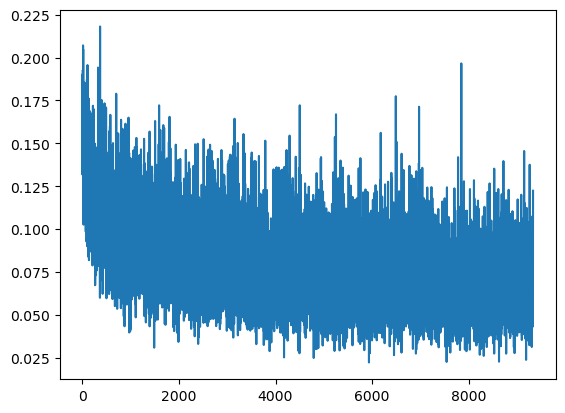

In [25]:
losses_ = [loss.detach().cpu().numpy().item() for loss in losses]
# import matplotlib.pyplot as plt
plt.plot(losses_[100:])
plt.show()

In [ ]:
notebook_login()
model.push_to_hub("t5-base-boolean-qgen_pretrained-finetuned")